
# Bagging and Random Forest
##  Bagging


###  Bagging classifier
Implementation of bagging to understand its internals and to use scikit-learn's bagging implementation.

**Listing**: Bagging with Decision Trees: Training

In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

def bagging_fit(X, y, n_estimators, max_depth=5, max_samples=200):
    n_examples = len(y)   
    estimators = [DecisionTreeClassifier(max_depth=max_depth)  
                  for _ in range(n_estimators)]  
    
    for tree in estimators:
        bag = np.random.choice(n_examples, max_samples, replace=True)  
        tree.fit(X[bag, :], y[bag])  
        
    return estimators

This function will return a list of [``DecisionTreeClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) objects. We can use this ensemble for prediction, by first obtaining the individual predictions and then aggregating them (through majority voting).

**Listing 2.2**: Bagging with Decision Trees: Prediction

In [2]:
from scipy.stats import mode

def bagging_predict(X, estimators):
    all_predictions = np.array([tree.predict(X) for tree in estimators])  
    y_pred, _ = mode(all_predictions, axis=0)  
    return np.squeeze(y_pred)

Let's test this on a 2d synthetic data set. We train a bagging ensemble of 500 decision trees, each of depth 10 on bootstrap samples of size 200.

In [3]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=300, noise=.25, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
bag_ens = bagging_fit(X_train, y_train, n_estimators=500,
                      max_depth=12, max_samples=200)
y_pred = bagging_predict(X_test, bag_ens)

print(accuracy_score(y_test, y_pred))

0.9191919191919192


In [7]:
ensembleAcc = accuracy_score(y_test, y_pred)
print('Bagging: Holdout accuracy = {0:4.2f}%.'.format(ensembleAcc * 100))

tree = DecisionTreeClassifier(max_depth=12)
y_pred_single = tree.fit(X_train, y_train).predict(X_test)
treeAcc = accuracy_score(y_test, y_pred_single)
print('Single Decision Tree: Holdout test accuracy = {0:4.2f}%.'.format(treeAcc * 100))

Bagging: Holdout accuracy = 91.92%.
Single Decision Tree: Holdout test accuracy = 93.94%.


We can visualize the difference between the bagging classifier and a single decision tree.

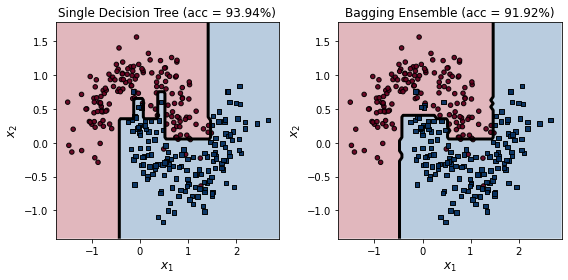

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
from visualization import plot_2d_classifier

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

title = 'Single Decision Tree (acc = {0:4.2f}%)'.format(treeAcc*100)
plot_2d_classifier(ax[0], X, y, colormap='RdBu', alpha=0.3,
                   predict_function=tree.predict,
                   xlabel='$x_1$', ylabel='$x_2$', title=title)

title = 'Bagging Ensemble (acc = {0:4.2f}%)'.format(ensembleAcc*100)
plot_2d_classifier(ax[1], X, y, colormap='RdBu', alpha=0.3,
                   predict_function=bagging_predict, predict_args=(bag_ens),
                   xlabel='$x_1$', ylabel='$x_2$', title=title)

fig.tight_layout()
plt.show()

---
###  Bagging with scikit-learn

``scikit-learn``'s [``BaggingClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) can be used to train a bagging ensemble for classification. It supports many different kinds of base estimators, though in the example below, we use ``DecisionTreeClassifier`` as the base estimator.

**Listing 2.3**: Baggimg with ``scikit-learn``

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

base_estimator = DecisionTreeClassifier(max_depth=10)
bag_ens = BaggingClassifier(base_estimator=base_estimator, n_estimators=500, 
                            max_samples=100, oob_score=True)
bag_ens.fit(X_train, y_train)
ypred = bag_ens.predict(X_test)

``BaggingClassifier`` supports out-of-bag evaluation and will return the oob accuracy if we set ``oob_score=True``, as we have done above. We have ourselves also held out a test set, with which we cancompute another estimate of this model’s generalization. These are both pretty close together, as we expect!

In [10]:
bag_ens.oob_score_

0.9502487562189055

In [11]:
accuracy_score(y_test, y_pred)

0.9191919191919192

We can visualize the smoothing behavior of the ``BaggingClassifier`` by comparing its decision boundary to its component base ``DecisionTreeClassifiers``.

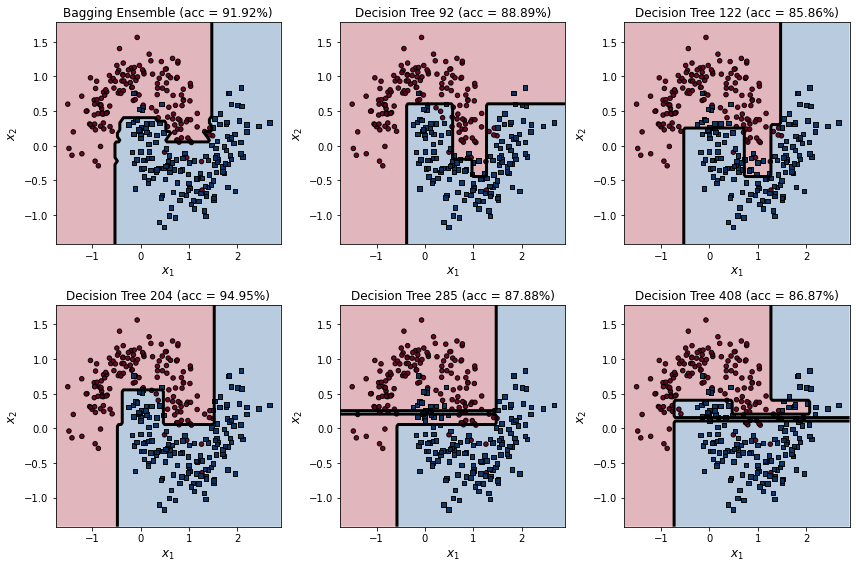

In [15]:
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
trees_to_plot = np.random.choice(500, 5, replace=True)

title = 'Bagging Ensemble (acc = {0:4.2f}%)'.format(accuracy_score(y_test, y_pred)*100)
plot_2d_classifier(ax[0, 0], X, y, colormap='RdBu', alpha=0.3,
                   predict_function=bag_ens.predict, 
                   xlabel='$x_1$', ylabel='$x_2$', title=title)

for i in range(5):
    r, c = np.divmod(i + 1, 3)  # Get the row and column index of the subplot
    j = trees_to_plot[i]
    
    test_acc_clf = accuracy_score(y_test, bag_ens[j].predict(X_test))
    
    bag = bag_ens.estimators_samples_[j] 
    X_bag = X[bag, :]
    y_bag = y[bag]
    
    title = 'Decision Tree {1} (acc = {0:4.2f}%)'.format(test_acc_clf*100, j+1)
    plot_2d_classifier(ax[r, c], X, y, colormap='RdBu', alpha=0.3,
                       predict_function=bag_ens[j].predict, 
                       xlabel='$x_1$', ylabel='$x_2$', title=title)

fig.tight_layout()
plt.show()

Once the sequential vs. parallel results have been loaded/run, plot them.

---

## Random Forest
Using ``scikit-learn``'s [``RandomForestClassifier``](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

**Listing 2.4**: Random Forest with ``scikit-learn``

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf_ens = RandomForestClassifier(n_estimators=500, max_depth=10, 
                               oob_score=True, n_jobs=-1)
rf_ens.fit(X_train, y_train)
y_pred = rf_ens.predict(X_test)

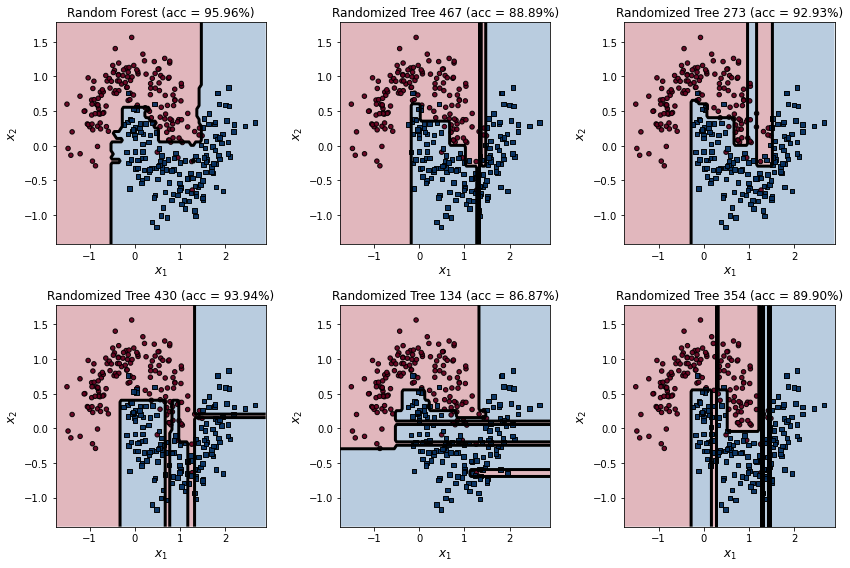

In [13]:
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
trees_to_plot = np.random.choice(500, 5, replace=True)

title = 'Random Forest (acc = {0:4.2f}%)'.format(accuracy_score(ytst, ypred)*100)
plot_2d_classifier(ax[0, 0], X, y, colormap='RdBu', alpha=0.3,
                   predict_function=rf_ens.predict, 
                   xlabel='$x_1$', ylabel='$x_2$', title=title)

for i in range(5):
    r, c = np.divmod(i + 1, 3)  # Get the row and column index of the subplot
    j = trees_to_plot[i]
    
    tst_acc_clf = accuracy_score(ytst, bag_ens[j].predict(Xtst))
    
    bag = bag_ens.estimators_samples_[j] 
    X_bag = X[bag, :]
    y_bag = y[bag]
    
    title = 'Randomized Tree {1} (acc = {0:4.2f}%)'.format(tst_acc_clf*100, j+1)
    plot_2d_classifier(ax[r, c], X, y, colormap='RdBu', alpha=0.3,
                       predict_function=rf_ens[j].predict, 
                       xlabel='$x_1$', ylabel='$x_2$', title=title)

fig.tight_layout()
plt.show()

``scikit-learn``'s ``RandomForestClassifier`` can also rank features by their importance. Feature importances can be extracted from the learned ``RandomForestClassifier``'s [``feature_importances_``](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_) attribute. This is computed by adding up how much each feature decreases the overall [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) criterion during training. Features that decrease the impurity more will have higher feature importances.

In [14]:
for i, score in enumerate(rf_ens.feature_importances_):
    print('Feature x{0}: {1:6.5f}'.format(i, score))

Feature x0: 0.45362
Feature x1: 0.54638
